In [2]:
#https://medium.com/swlh/using-q-learning-for-openais-cartpole-v1-4a216ef237df

In [18]:
import gym
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import time, math, random
from typing import Tuple
import tqdm
import matplotlib.pyplot as plt

# Q-Learning

q(s,a) = q(sa-a) + lr(r+ymaxq(s',a'))
ymax: Discount factor (0,1)
a': Future action
s': Future state

In [15]:
environment = gym.make('CartPole-v1')

#Q-table
#Actions: left - right
print(environment.action_space.n)

2


In [19]:
class CartPoleAgent:
    def __init__(self, env, episodes):
        self.env = env
        # One table: actions * possible angles, second: actions*pole_vels
        self.n_bins = (6, 12)
        self.q_table = np.zeros(self.n_bins + (env.action_space.n, ))
        self.lower_bounds = [env.observation_space.low[2], -math.radians(50)]
        self.upper_bounds = [env.observation_space.high[2], math.radians(50)]
        self.lr = 0.1
        self.min_lr_rate = 0.1
        self.min_explo_rate=0.1
        self.decay = 24
        self.discount = 1.0
        self.episodes = episodes

    #Gets dsicrete value since the original state is contionus (time)
    def get_discrete(self, state):
        _, __, angle, pole_vel = state
        est = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy='uniform')
        est.fit([self.lower_bounds, self.upper_bounds])
        return tuple(map(int, est.transform([[angle, pole_vel]])[0]))
    # Returns the policy used for getting the next action (highest value in q table next)
    def get_policy(self, state):
        return np.argmax(self.q_table[state])

    #Q function used to update the prev q-value
    def update_q_value(self, reward, state, action, new_state):
        return self.lr * (reward + self.discount * np.max(self.q_table[new_state]) - self.q_table[state][action])

    #Adaptive lr. Used to adapt the learning rate
    def get_lr(self, n):
        return max(self.min_lr_rate, min(1.0, 1.0 - math.log10((n+1) / self.decay)))

    #Decaying explo rate/epsilon
    def get_explo_rate(self, n):
        return max(self.min_explo_rate, min(1.0, 1.0 - math.log10((n+1) / self.decay)))


    def train(self):
        scores = []
        for e in tqdm.tqdm(range(self.episodes)):
            current_state = self.get_discrete(self.env.reset())
            self.lr = self.get_lr(e)
            done = False
            #Tracks how many inputs it survives
            score = 0
            while not done:
                action = self.get_policy(current_state)

                #Random action (exploration). Every x amount of times the agent should do a random action
                if np.random.random() <= self.get_explo_rate(e):
                    action = self.env.action_space.sample()

                #After each step an observable state, reward and if it is done is returned
                obs, reward, done, _ = self.env.step(action)
                #Discretes the new state
                new_state = self.get_discrete(obs)

                #Gets new q-value
                #learnt_value = self.update_q_value(reward, current_state, action, new_state)
                self.q_table[current_state][action] += self.update_q_value(reward, current_state, action, new_state)
                #Gets old val from q-table

                current_state = new_state
                #For each loop it statys above 12 degs, it adds to the score
                score += 1

            scores.append(score)

        #print(scores)
        print("Training done!")
        return scores





In [21]:
import warnings
warnings.filterwarnings('ignore')
model = CartPoleAgent(environment, episodes=2000)
scores = model.train()


#print(model.get_discrete_state())

100%|██████████| 2000/2000 [02:50<00:00, 11.76it/s]

Training done!


[21, 9, 16, 21, 18, 19, 21, 17, 40, 40, 18, 12, 20, 19, 10, 41, 12, 18, 68, 17, 18, 12, 15, 21, 25, 19, 45, 19, 32, 14, 14, 19, 29, 21, 15, 40, 15, 24, 14, 33, 18, 23, 12, 57, 34, 28, 12, 39, 36, 12, 29, 24, 19, 31, 11, 28, 25, 17, 22, 37, 8, 16, 59, 15, 59, 25, 10, 10, 13, 59, 37, 29, 16, 9, 38, 31, 67, 65, 99, 22, 43, 33, 13, 28, 18, 22, 25, 17, 29, 78, 17, 112, 17, 108, 32, 28, 14, 71, 29, 26, 18, 26, 31, 88, 32, 24, 33, 94, 30, 52, 197, 62, 37, 48, 53, 53, 77, 58, 147, 67, 172, 117, 60, 64, 137, 150, 113, 22, 18, 69, 43, 28, 14, 60, 9, 11, 44, 60, 29, 55, 65, 107, 81, 500, 267, 500, 475, 260, 500, 500, 462, 55, 427, 225, 33, 251, 205, 500, 482, 348, 500, 343, 500, 500, 500, 344, 500, 500, 500, 500, 356, 500, 307, 500, 386, 461, 500, 500, 500, 500, 500, 500, 500, 500, 472, 476, 500, 500, 500, 379, 500, 500, 500, 500, 500, 500, 500, 500, 365, 500, 500, 500, 500, 500, 497, 500, 500, 500, 500, 436, 335, 450, 500, 500, 500, 500, 500, 500, 500, 500, 500, 446, 475, 500, 500, 500, 500, 476

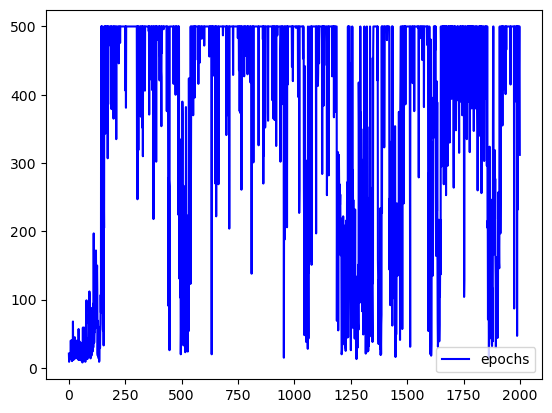

In [22]:
#print(model.q_table)
print(scores)
plt.plot(scores,  c='blue', label='epochs')
plt.legend()